In [35]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## Upload the data and prepare for analysis


In [36]:
# last version of the data 
df_firms = pd.read_excel('firms_data/firms_adaptation_final_merged.xlsx')



In [37]:
# rename Total Purchase Imports €m 
# all data
df_firms = df_firms.rename(columns={'Total Purchase for local use €m': 'Purchases'})
df_firms = df_firms.rename(columns={'Total Purchase €m': 'Total_purchase'})
df_firms = df_firms.drop(columns=['Sector'])
df_firms = df_firms.rename(columns={'NACE Code (purchasing)': 'Sector'})
df_firms = df_firms.rename(columns={'Level 3': 'Product'})
df_firms['Purchases'] = pd.to_numeric(df_firms['Purchases'])

In [38]:


# change Fiscal Year in Year and keep only the first 4 digits
df_firms['Year'] = df_firms['Fiscal Year'].astype(str).str[:4]
# drop the column Fiscal Year
df_firms = df_firms.drop(columns=['Fiscal Year'])

# rename 'Type of Event' to 'Event' and 'Timing of Measure' to 'Timing'
df_firms = df_firms.rename(columns={'Type of Event': 'Event'})
df_firms = df_firms.rename(columns={'Timing of Measure': 'Timing'})
# Rename City to Location
df_firms = df_firms.rename(columns={'Region': 'Aggr_region'})
df_firms = df_firms.rename(columns={'Total Purchase Imports €m': 'Imports'})
df_firms = df_firms.rename(columns={'Total Number of Employees (Purchase for local use)': 'Total_employee'})
df_firms = df_firms.rename(columns={'Number of Companies all including part time (Purchase for local use)': 'Total_companies'})
df_firms = df_firms.rename(columns={'Global Market Share %': 'Global_market_share'})
df_firms = df_firms.rename(columns={'R&D spending €m ': 'R&D_spending'})

In [39]:
df_firms['Local_production'] = df_firms['Purchases'] - df_firms['Imports']
df_firms['Average_size'] = df_firms['Total_employee'] / df_firms['Total_companies']
df_firms['Local_purchase'] = df_firms['Purchases'] - df_firms['Imports']
df_firms['Local_purchase_ratio'] = df_firms['Purchases'] / df_firms['Total_purchase']

In [40]:
df_firms['Purchase_bn'] = df_firms['Purchases'] / 1000

## Some descriptive analysis

In [41]:
df_firms['Actor'] = 'Private'
# remove the rows where sector  =  'O. Public administration and defence; compulsory social security'
df_firms.loc[df_firms['Sector'] == 'O. Public administration and defence; compulsory social security', 'Actor'] = 'Public'

## Figure 2 of the paper

In [42]:
# group by capital, sum purchase 
df_firms_cca_private = df_firms.loc[df_firms['Actor'] == 'Private'].groupby(['Adaptation_category_1', 'Adaptation_category_gold' ])['Purchases'].sum().reset_index()
# int purchase
df_firms_cca_private['Purchases'] = df_firms_cca_private['Purchases'].astype(int)
df_firms_cca_private['Purchases (€bn)'] = df_firms_cca_private['Purchases'] / 1000

In [43]:

import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Calculate total purchases for scaling
total_purchases = df_firms_cca_private['Purchases (€bn)'].sum()

# Add a new column to check if value is less than 2%
df_firms_cca_private['percent'] = df_firms_cca_private['Purchases (€bn)'] / total_purchases * 100

# Create the sunburst chart without text labels
fig = px.sunburst(
    df_firms_cca_private,
    path=['Adaptation_category_1', 'Adaptation_category_gold'],
    values='Purchases (€bn)',
    color='Purchases (€bn)',
    color_continuous_scale='RdBu_r',
    hover_data={'Purchases (€bn)': True, 'percent': ':.2f'},
    labels={'Purchases (€bn)': 'Purchases (€bn)'},
    #title='Adaptation Category and Gold Analysis',
    width=700
)

# Remove text labels from inside the chart
fig.update_traces(
    textinfo='none'  # Hide labels inside the chart
)

# Update layout of the sunburst chart
fig.update_layout(
    coloraxis_colorbar=dict(title='Purchases (€bn)'),
    width=900,
    height=600
)


fig.show()

## Figure 4 of the paper

#### Relative contribution 

In [44]:
# in df_firms, in the columns aggr_region, rename: 'Texas' to 'US-T', 'Florida' to 'US-F', 'South Holland' to 'NL-R', 'Jabodetabek' to 'ID-J', 'Jaing-Zhe-Hu' to 'CN-S'
df_firms['Aggr_region'].unique()
df_firms['Aggr_region'] = df_firms['Aggr_region'].replace(['Texas'], 'US-T')
df_firms['Aggr_region'] = df_firms['Aggr_region'].replace(['Florida'], 'US-F')
df_firms['Aggr_region'] = df_firms['Aggr_region'].replace(['South Holland'], 'NL-R')
df_firms['Aggr_region'] = df_firms['Aggr_region'].replace(['Jabodetabek'], 'ID-J')
df_firms['Aggr_region'] = df_firms['Aggr_region'].replace(['Jaing-Zhe-Hu'], 'CN-S')

In [45]:
df_firms['Sector_letter'] = df_firms['Sector'].str.get(0)
df_firms['Sector_short'] = df_firms['Sector'].str.split(' ', n=2).str[:2].str.join(' ')
df_firms['Aggregate_sector'] = df_firms['Sector_letter']
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['A'], 'Agriculture')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['B', 'C'], 'Industry')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['D', 'E'], 'Utilities')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['F'], 'Construction')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['G'], 'Wholesale and Retail')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['H'], 'Transportation')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S'], 'Private Services')
df_firms['Aggregate_sector'] = df_firms['Aggregate_sector'].replace(['O'], 'Public Services')




In [46]:
df_grouped= df_firms.groupby(['Aggr_region', 'Aggregate_sector'])['Purchase_bn'].sum().unstack().fillna(0)

In [47]:
df_census = pd.read_excel('firms_data/Delft_firm_cca_15_05_24.xlsx', sheet_name='Total_sectors')
df_census['Aggr_region'] = df_census['Aggr_region'].replace(['Texas'], 'US-T')
df_census['Aggr_region'] = df_census['Aggr_region'].replace(['Florida'], 'US-F')
df_census['Aggr_region'] = df_census['Aggr_region'].replace(['South Holland'], 'NL-R')
df_census['Aggr_region'] = df_census['Aggr_region'].replace(['Jabodetabek'], 'ID-J')
df_census['Aggr_region'] = df_census['Aggr_region'].replace(['Jaing-Zhe-Hu'], 'CN-S')

In [48]:
df_census['Sector_letter'] = df_census['Sector'].str.get(0)
df_census['Sector_short'] = df_census['Sector'].str.split(' ', n=2).str[:2].str.join(' ')
df_census['Aggregate_sector'] = df_census['Sector_letter']
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['A'], 'Agriculture')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['B', 'C'], 'Industry')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['D', 'E'], 'Utilities')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['F'], 'Construction')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['G'], 'Wholesale and Retail')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['H'], 'Transportation')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S'], 'Private Services')
df_census['Aggregate_sector'] = df_census['Aggregate_sector'].replace(['O'], 'Public Services')

In [49]:
df_grouped_census = df_census.groupby(['Aggr_region', 'Aggregate_sector'])['Sales'].sum().unstack().fillna(0)

In [50]:
df_grouped_relative = df_grouped / df_grouped_census

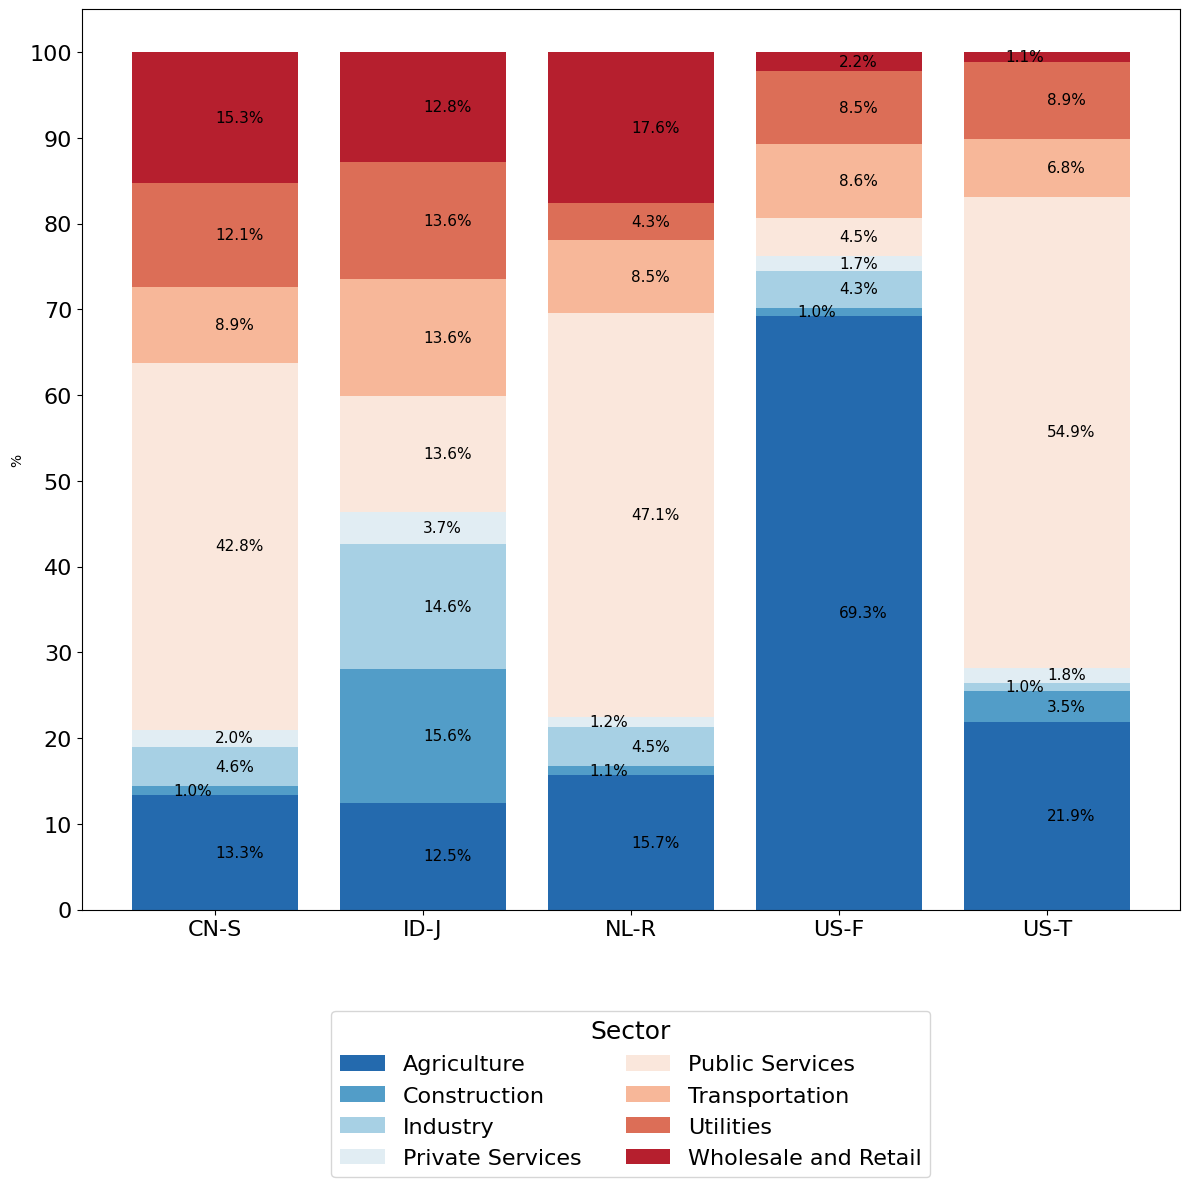

In [51]:

# Normalize the data by row to get the relative percentage for each sector
df_normalized = df_grouped_relative.div(df_grouped_relative.sum(axis=1), axis=0) * 100

# Define the color palette for each sector
# I want a redf to blue color palette
palette = sns.color_palette("RdBu", len(df_normalized.columns))
# invert the palette
palette = palette[::-1]


# Plotting the normalized data with percentages
fig, ax = plt.subplots(figsize=(12, 12))

# We need to stack each sector on top of the previous one, so we keep track of the bottom position
bottom = np.zeros(len(df_normalized))

for i, sector in enumerate(df_normalized.columns):
    bars = ax.bar(df_normalized.index, df_normalized[sector], bottom=bottom, label=sector, color=palette[i])
    # Update the bottom position for the next sector
    bottom += df_normalized[sector].values



    # Adding the text inside the bars with alternating positions by sector
    for bar in bars:
        height = bar.get_height()
        if height < 1.6:  # Only show text if the bar height is significant
            # Calculate x position based on alignment
            # Adjust x position for 'right' alignment to be on the left side of center
            # and for 'left' alignment to be on the right side of center
            x_offset = -0.20
        else:
            x_offset = 0
        x_position = bar.get_x() + bar.get_width() / 2 + x_offset

            # Add text annotation
        ax.text(x_position, bar.get_y() + height / 2, f'{height:.1f}%', 
                     va='center', color='black', fontsize=11)

# Customizing the plot to match the provided image
ax.set_ylabel('%')
#ax.set_title('Investment by Sector and Region (Normalized)')
# legend below the figures and in 3 columns
ax.legend(title='Sector', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2, fontsize=16, title_fontsize=18)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 101, 10))
# MAKE  tick label bigger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ensure the layout is not too tight
plt.tight_layout()

# Show the plot
plt.show()


## Now we look at Figure 5 of the paper

In [52]:
df_firms
# groupt by Aggr_region, sector and sum Purchases
df_firms_grouped_sector = df_firms.groupby(['Aggr_region', 'Aggregate_sector', 'Adaptation_category_1' ])['Purchases'].sum().reset_index()
# make a column log purchases and rename Aggr_region to Region
df_firms_grouped_sector['Log_purchases'] = np.log(df_firms_grouped_sector['Purchases'])
# rename the column 


In [53]:
df_firms_grouped_sector
# in 'Adaptation_category_1', rename 'Eba' to 'EbA'
df_firms_grouped_sector['Adaptation_category_1'] = df_firms_grouped_sector['Adaptation_category_1'].replace(['Eba'], 'EbA')

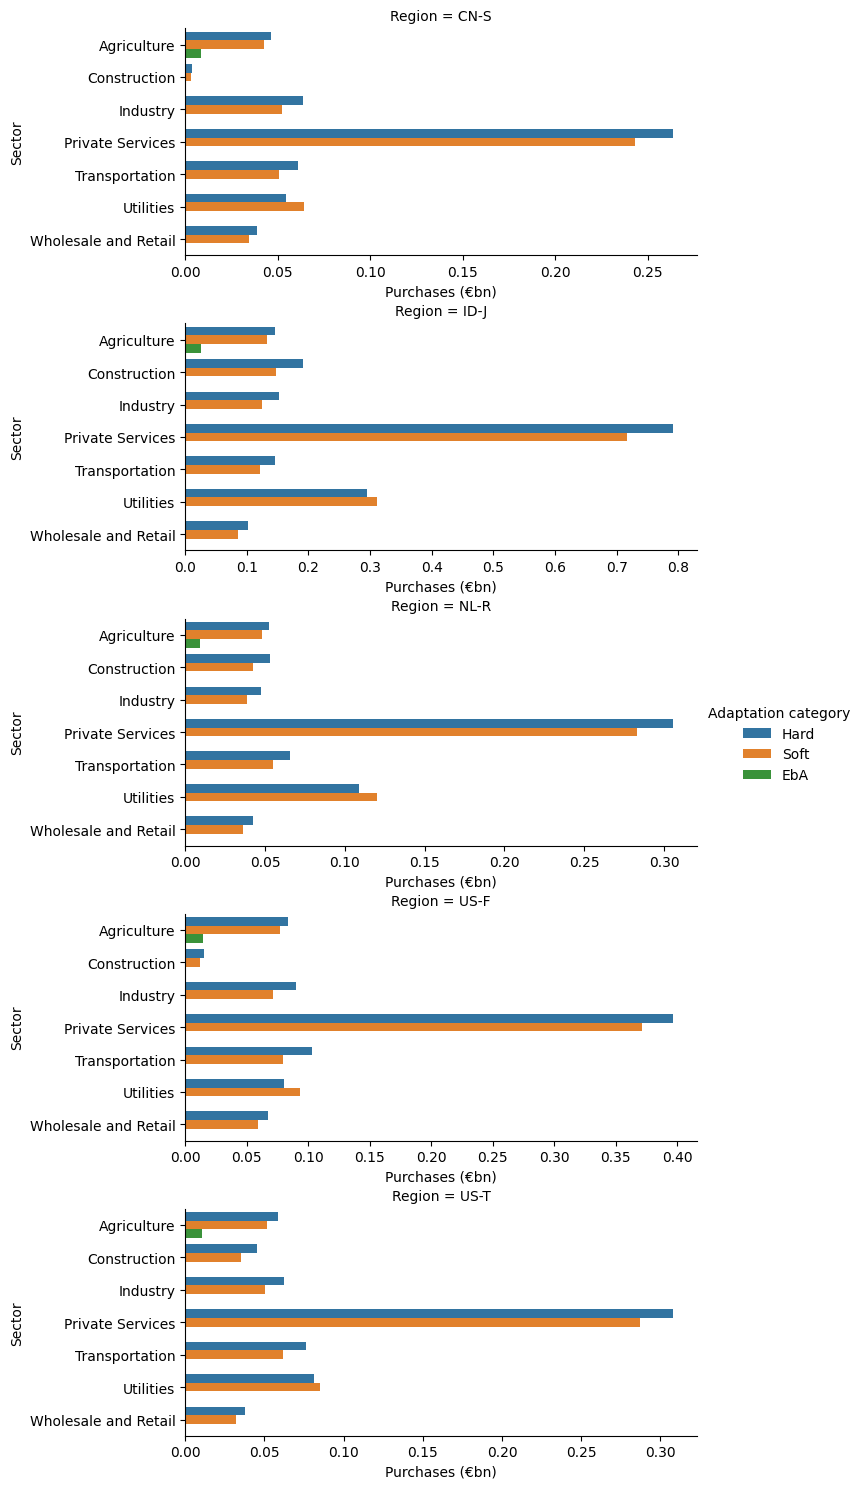

In [54]:
# Rename the columns
df_firms_grouped_sector = df_firms_grouped_sector.rename(columns={'Aggr_region': 'Region', 'Adaptation_category_1': 'Adaptation category', 'Purchases': 'Purchases (€m)'})
df_firms_grouped_sector['Purchases (€bn)'] = df_firms_grouped_sector['Purchases (€m)'] / 1000


# Create a more compact and wide catplot with 'Region' as rows, 'Adaptation category' as hue
g = sns.catplot(x='Purchases (€bn)', y='Aggregate_sector', hue='Adaptation category', row='Region',  hue_order=['Hard', 'Soft', 'EbA'],
                data=df_firms_grouped_sector.loc[df_firms_grouped_sector['Aggregate_sector'] != 'Public Services'], kind='bar', height=3, aspect=2.5, orient='h', sharex=False)

for ax in g.axes.flat:
    ax.set_xlabel('Purchases (€bn)')
    ax.set_ylabel('Sector')

# Add more space between the subplots
plt.subplots_adjust(hspace=0.3)
# Display the plot
plt.show()